In [65]:
import numpy as np
import networkx as nx
import math
import random
#from sklearn.cluster import KMeans
from typing import List
import matplotlib

WAREHOUSE_COLOR = 'magenta'
def get_truck_colors(n_trucks : int) -> List[str]:
    cmap = matplotlib.colormaps['turbo']
    color_rgba  = cmap(np.linspace(0.0,1.0,n_trucks))
    colors_hex = []
    for c in color_rgba:
        
        colors_hex.append('#{:02x}{:02x}{:02x}'.format(*(c*255).astype(int)))
    return colors_hex

class VRP:
    def __init__(self,map_width : float , map_height : float, n_clients : int, n_trucks : int, truck_capacity : float = 50 ,warehouse_loc : tuple[float,float] = None) :
        self.n_clients = n_clients
        self.n_trucks = n_trucks
        self.truck_capacity = truck_capacity
        self.POPULATION_SIZE = 100
        if warehouse_loc is None:
            self.warehouse_loc = (random.random()*map_width,random.random()*map_height)
        else:
            self.warehouse_loc = warehouse_loc
        self.population = np.zeros((self.POPULATION_SIZE,n_clients),dtype=int)
        self.capacities = np.zeros((self.POPULATION_SIZE,n_clients),dtype=float)
        #GRAPH
        client_locations_x = np.random.random((n_clients,1))*map_width
        client_locations_y = np.random.random((n_clients,1))*map_height
        self.client_locations = np.hstack([client_locations_x,client_locations_y])
        self.graph = nx.Graph()
        for i,(x,y) in enumerate(self.client_locations):
            self.graph.add_node(i,pos=(x,y))
        self.graph.add_node(-1,pos=self.warehouse_loc)
        
        for i,(x,y) in enumerate(self.client_locations):
            self.graph.add_edge(i,-1,weight = math.sqrt((self.warehouse_loc[0]-x)**2+(self.warehouse_loc[1]-y)**2),color='r')

            
        #TODO: renderlo piu efficiente con n*(n-1)/2
        for i,(x,y) in enumerate(self.client_locations):
            for j,(xx,yy) in enumerate(self.client_locations):
                if i!= j:
                    self.graph.add_edge(i,j,weight = math.sqrt((xx-x)**2+(yy-y)**2))
                    
    def draw_problem(self, show_edges : bool = False):
        node_color = []
        for node in self.graph:
            node_color.append("yellow" if node == -1 else "coral")
        if show_edges:
            nx.draw(self.graph, nx.get_node_attributes(self.graph, 'pos'), with_labels=True, node_size=150,node_color = node_color)
        else:
            nx.draw_networkx_nodes(self.graph, nx.get_node_attributes(self.graph, 'pos'), node_size=100,node_color = node_color)
            
    def init_random_population(self):
        #self.population = np.random.randint(0, self.n_trucks, size=(self.POPULATION_SIZE,self.n_clients))
        array =  np.arange(0,self.n_clients)
        self.population = np.tile(array, (self.POPULATION_SIZE, 1)) 
        #print(self.population)
        #self.population[np.arange(len(self.population))[:,None], np.random.randn(*self.population.shape).argsort(axis=1)]
        self.population = np.apply_along_axis(np.random.permutation, axis=1, arr=self.population)
        self.capacities = np.random.random((self.POPULATION_SIZE,self.n_clients)) * self.truck_capacity/1.2
        #print("aaaaaaaaaaaaa")
        #print(self.population)
    def fitness_function(self,index):
        #USES A GREEDY APPROACH DESCRIBED IN https://www.researchgate.net/publication/268043232_Comparison_of_eight_evolutionary_crossover_operators_for_the_vehicle_routing_problem 
        curr_chromosome = self.population[index]
        routes = []
        curr_route = ["B",curr_chromosome[0]]
        curr_truck = 0
        total_distance = self.graph.edges[(-1,curr_chromosome[0])]['weight']
        capacity_curr = self.capacities[index][curr_chromosome[0]]
        for i in range(1,len(curr_chromosome)):
            capacity_curr += self.capacities[index][curr_chromosome[i]]
            
            #print(capacity_curr)
            if capacity_curr > self.truck_capacity:
                #ended route
                print(f"Ending route: truck number {curr_truck} filled with {capacity_curr-self.capacities[index][curr_chromosome[i]]} kg")
                #capacity_curr = 0
                curr_truck+=1
                total_distance+=self.graph.edges[(curr_chromosome[i-1],-1)]['weight']
                curr_route.append("B")
                routes.append(curr_route)
                curr_route = ["B",curr_chromosome[i]]
                total_distance+=self.graph.edges[(-1,curr_chromosome[i])]['weight']
                capacity_curr = self.capacities[index][curr_chromosome[i]]
            else:
                curr_route.append(curr_chromosome[i])
                total_distance+=self.graph.edges[(curr_chromosome[i-1],curr_chromosome[i])]['weight']
        curr_route.append("B")
        routes.append(curr_route)
        total_distance+=self.graph.edges[(len(curr_chromosome)-1,-1)]['weight']
        curr_truck += 1
        print(f"total distance: {total_distance}")
        print(f"number of used trucks: {curr_truck}")
        if curr_truck > self.n_trucks:
            raise Exception("Numero di camion nella soluzione superiore al consentito")
        return total_distance, routes
                
                
            
            


In [70]:
np.random.seed(42)
random.seed(42)
vrp = VRP(200,200,4,2)
vrp.init_random_population()
print(vrp.population[0])
vrp.fitness_function(0)

#vrp.capacities[0]

[0 1 2 3]
Ending route: truck number 0 filled with 16.113972762522387 kg
Ending route: truck number 1 filled with 44.76045553678033 kg
total distance: 590.1975936402307
number of used trucks: 3


Exception: Numero di camion nella soluzione superiore al consentito

In [71]:
vrp.capacities[0][3]=1

In [72]:
vrp.capacities[0]

array([16.11397276, 39.0304162 ,  5.73003934,  1.        ])

In [73]:
vrp.fitness_function(0)

Ending route: truck number 0 filled with 16.113972762522387 kg
total distance: 565.9112201213521
number of used trucks: 2


(565.9112201213521, [['B', 0, 'B'], ['B', 1, 2, 3, 'B']])

In [74]:
a = vrp.graph.edges[(-1,0)]['weight']*2
a

118.20525810629121

In [8]:
b= vrp.graph.edges[(-1,1)]['weight'] +vrp.graph.edges[(1,2)]['weight'] +vrp.graph.edges[(2,-1)]['weight']
b

135.1312318818564

In [9]:
c = vrp.graph.edges[(-1,3)]['weight']*2
c

336.861103652083

In [10]:
a+b+c

590.1975936402306

In [50]:
vrp = VRP(200,200,50,n_trucks=4)
#vrp.draw_problem(True)

#vrp.init_random_population()
vrp.init_kmeans_population(random_init_p=0.10)
#print(vrp.population)

%time vrp.draw_chromosome_paths(chromosome_index=2,approximate = False)

Exception: 

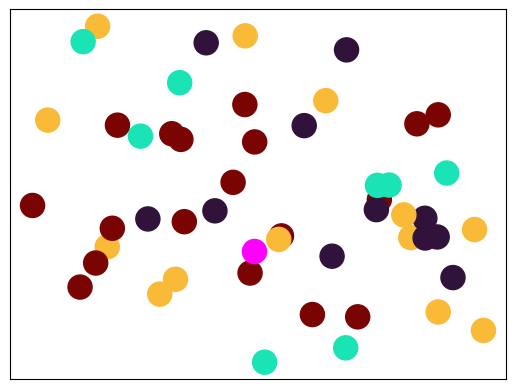

In [39]:
vrp.draw_chromosome()

/tmp/ipykernel_27009/851964595.py:118: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(tsp_graph,nx.get_node_attributes(self.graph, 'pos'),edge_color=edge_color)


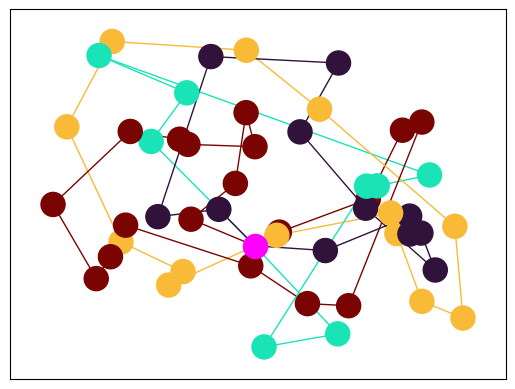

In [40]:
vrp.draw_chromosome_paths()

In [41]:
vrp.population[0]

array([1, 1, 2, 0, 2, 3, 0, 3, 2, 0, 3, 3, 3, 2, 0, 0, 2, 1, 3, 1, 3, 0,
       0, 0, 3, 2, 2, 2, 3, 2, 3, 1, 1, 0, 3, 1, 0, 0, 1, 2, 3, 2, 3, 3,
       3, 3, 3, 2, 2, 3])

In [42]:
np.arange(0,10,1)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [43]:
vrp.init_random_population()

[[ 0  1  2 ... 47 48 49]
 [ 0  1  2 ... 47 48 49]
 [ 0  1  2 ... 47 48 49]
 ...
 [ 0  1  2 ... 47 48 49]
 [ 0  1  2 ... 47 48 49]
 [ 0  1  2 ... 47 48 49]]
aaaaaaaaaaaaa
[[ 0  1  2 ... 47 48 49]
 [ 0  1  2 ... 47 48 49]
 [ 0  1  2 ... 47 48 49]
 ...
 [ 0  1  2 ... 47 48 49]
 [ 0  1  2 ... 47 48 49]
 [ 0  1  2 ... 47 48 49]]


In [36]:
vrp.population

array([ 0,  1,  2, ..., 47, 48, 49])

In [65]:
np.random.permutation(vrp.population[0])

array([38, 45,  4, 42,  6, 32, 25, 34, 28, 33,  9, 21, 35, 49, 40, 16, 31,
       36, 30, 18, 48, 17, 47, 26, 44, 39,  5,  1,  7, 14,  2, 23, 29,  3,
       24, 27, 13, 19,  8, 12, 41, 15,  0, 10, 46, 37, 43, 22, 20, 11])

In [68]:

            
    ########################LE FUNZIONI DA QUA IN GIU VANNO CAMBIATE############################################
    def init_kmeans_population(self,random_init_p : float = 0.0):
        raise Exception
        locs = [ (loc[0],loc[1]) for loc in self.client_locations]
        #locs.append(self.warehouse_loc)
        for i in range(self.POPULATION_SIZE):
            if random.random() < random_init_p:
                self.population[i] = np.random.randint(0, self.n_trucks, size=(self.n_clients))
            else:
                kmeans = KMeans(n_clusters=self.n_trucks,n_init='auto',max_iter=1,init='random').fit(locs)
                self.population[i]= kmeans.predict(locs)
            
        
    def draw_chromosome(self,chromosome_index : int = 0):
        raise Exception
        colors = get_truck_colors(self.n_trucks)
        node_color_map = []
        for client,truck in enumerate(self.population[chromosome_index]):
            node_color_map.append(colors[truck])
        drawn_nodes = list(self.graph.nodes)
        drawn_nodes.remove(-1)
        nx.draw_networkx_nodes(self.graph,nx.get_node_attributes(self.graph, 'pos'),nodelist = drawn_nodes,node_color = node_color_map)
        nx.draw_networkx_nodes(self.graph,nx.get_node_attributes(self.graph, 'pos'),nodelist = [-1],node_color = WAREHOUSE_COLOR)
        
    def draw_chromosome_paths(self,chromosome_index : int = 0, approximate : bool = False):
        raise Exception
        colors = get_truck_colors(self.n_trucks)
        node_color_map = []
        for client,truck in enumerate(self.population[chromosome_index]):
            node_color_map.append(colors[truck])
        tsp_graph = nx.Graph()
        for i,(x,y) in enumerate(self.client_locations):
            tsp_graph.add_node(i,pos=(x,y))
        tsp_graph.add_node(-1,pos = self.warehouse_loc)
        for truck in range(self.n_trucks):
            
            indices = np.where(self.population[chromosome_index] == truck)[0]
            #random_path[indices]
            indices = np.append(indices,[-1])
            if approximate:
                g = nx.subgraph(self.graph,indices)
                tsp_solution = nx.approximation.traveling_salesman.simulated_annealing_tsp(g,init_cycle='greedy',temp = 5000)
            else:
                tsp_solution = nx.approximation.traveling_salesman_problem(self.graph,nodes = indices)
            
            #list(indices)
            for i in range(len(tsp_solution)-1):
                tsp_graph.add_edge(tsp_solution[i],tsp_solution[i+1])
        edge_color = []
        for e in tsp_graph.edges():
            edge_color.append(node_color_map[e[0] if e[0]!=-1 else e[1]])

        drawn_nodes = list(self.graph.nodes)
        drawn_nodes.remove(-1)
        nx.draw_networkx_nodes(tsp_graph,nx.get_node_attributes(self.graph, 'pos'),nodelist = drawn_nodes,node_color = node_color_map)
        nx.draw_networkx_nodes(self.graph,nx.get_node_attributes(self.graph, 'pos'),nodelist = [-1],node_color = WAREHOUSE_COLOR)
        nx.draw_networkx_edges(tsp_graph,nx.get_node_attributes(self.graph, 'pos'),edge_color=edge_color)

80.90312091742085